I built  a tiny GAN on MNIST

Generator maps a random noise vector (100-D) → 28×28 grayscale image.

Discriminator  binary classifier that judges an image as real (1) or fake (0).

alternate training D and G so the generator learns to produce images that fool the discriminator.

In [ ]:
# Imports & dataset (setup)

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [ ]:

# Loading MNIST dataset
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28, 1) shape becomes adding a fake dimension size and chanel


In [ ]:
noise_dim = 100 # length of random vector fed to generator.
image_shape = (28, 28, 1)
batch_size = 128


Start with noise vector z in latent space  (100 dims).

Project it to 128 neurons, nonlinearity (ReLU) gives capacity.

Project to 28*28 and use sigmoid → values in [0,1] to match image scale.

Reshape to 28×28×1.
Note: This is a very small generator (dense-only). Works for demo but not for photorealism.

In [ ]:

# BUILDING MY  GENERATOR
def susnata_build_generator(noise_dim):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=noise_dim))
    model.add(Dense(28 * 28, activation="sigmoid"))
    model.add(Reshape((28, 28, 1)))
    return model
------

Flatten image → dense layer → final sigmoid neuron outputs a probability p  (0,1) that the image is real.

Optimizer & loss are chosen below.

In [ ]:
#  BUILDING MY  DISCRIMINATOR
def susnata_build_discriminator(image_shape):
    model = Sequential()
    model.add(Flatten(input_shape=image_shape))
    model.add(Dense(128, activation="relu"))# relu in hidden
    model.add(Dense(1, activation="sigmoid")) # as binary
    return model


First, we make the discriminator and compile it (so it can be trained standalone).

Before creating the combined gan_model, we set discriminator.trainable = False — important: this ensures that when we call gan_model.train_on_batch(...), only the generator weights are updated (we want gradients from D but not to update D there).

gan_model connects noise_input → generator → discriminator → validity_output.

Both discriminator and gan use binary crossentropy because the output is a probability.

In [ ]:
# CREATE MODELS G PLUS D IN GAN
susnata_discriminator = susnata_build_discriminator(image_shape)
susnata_discriminator.compile(optimizer="adam", loss="binary_crossentropy")

susnata_discriminator.trainable = False   # freeze for GAN build

susnata_generator = susnata_build_generator(noise_dim)
noise_input = tf.keras.Input(shape=(noise_dim,))
generated_image = susnata_generator(noise_input)
validity_output = susnata_discriminator(generated_image)
gan_model = tf.keras.Model(noise_input, validity_output)
gan_model.compile(loss="binary_crossentropy", optimizer="adam")


real_labels: what D should predict for real images (1).

fake_labels: what D should predict for generated images (0).

In [ ]:
# TRAINING PARAMS
epochs = 300
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))


Train D on real images: pick a random batch from x_train, label them 1 and run train_on_batch.

Train D on fake images: sample noise, generate fake images, label them 0 and train D.

d_loss = 0.5*(d_loss_real + d_loss_fake) is a simple average for monitoring.

Train G (via gan_model): freeze D weights (trainable=False) and train the combined model where the target labels are real_labels (1) for the generated images.

This is the adversarial step: the generator is updated so that D (which is frozen for this step) will output values closer to 1 for its fakes—i.e., fool D into thinking fakes are real.

Repeat epochs times.

Why i am doing freeze/unfreeze?

When training D, D must be trainable.

When training G via the combined model, D must be frozen so only G updates (we rely on D’s gradients, not its parameter change).

In [ ]:
# TRAINING LOOP
for step in range(epochs):

    #  Train Discriminator
    susnata_discriminator.trainable = True

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    fake_imgs = susnata_generator.predict(noise, verbose=0)

    d_loss_real = susnata_discriminator.train_on_batch(real_imgs, real_labels)
    d_loss_fake = susnata_discriminator.train_on_batch(fake_imgs, fake_labels)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    #  Train Generator
    susnata_discriminator.trainable = False
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    g_loss = gan_model.train_on_batch(noise, real_labels)

    #  Logs
    if step % 50 == 0:
        print(f"Step {step}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")


Step 0/300 | D Loss: 0.8888 | G Loss: 1.2127
Step 50/300 | D Loss: 0.0649 | G Loss: 4.6562
Step 100/300 | D Loss: 0.0539 | G Loss: 4.5206
Step 150/300 | D Loss: 0.0698 | G Loss: 4.2457
Step 200/300 | D Loss: 0.0598 | G Loss: 4.3721
Step 250/300 | D Loss: 0.0517 | G Loss: 4.5508


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


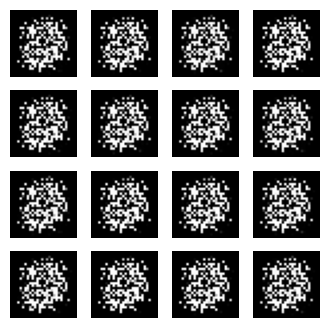

In [ ]:
sample_noise = np.random.normal(0,1,(16, noise_dim))
gen_imgs = susnata_generator.predict(sample_noise)

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(gen_imgs[i,:,:,0], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
susnata_generator.save("susnata_generator.h5")

In [ ]:
from tensorflow.keras.models import load_model
gen = load_model("susnata_generator.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

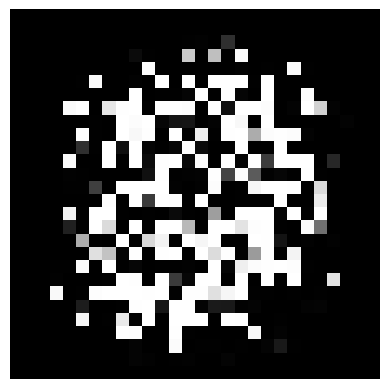

In [ ]:
noise = np.random.normal(0,1,(1, noise_dim))
img = gen.predict(noise)
plt.imshow(img[0,:,:,0], cmap="gray")
plt.axis("off")

I built a minimal GAN: a generator that converts random noise to 28×28 images and a discriminator that judges real vs fake. Training alternates between teaching the discriminator to distinguish real/fake, and teaching the generator to produce images that the discriminator labels as real. This demo captures the core adversarial idea—simple, elegant, and the perfect playground for learning GAN mechanics.

GAN Training Notes & Observations (MNIST Experiment)
1. Ideal GAN Loss Behaviour

In a healthy GAN training process:

Discriminator Loss (D-Loss)
Should stay low or moderate.
Reason:
The discriminator’s job is to be strict and correctly classify
real → 1 and fake → 0.
A low D-loss means the discriminator is doing its job properly.

Generator Loss (G-Loss)
Usually stays higher than D-loss, especially in early training.
Reason:
The generator is constantly being punished for producing unrealistic images and is trying to fool a strict discriminator.
So, its loss should naturally be higher.

In short:
👉 Strict discriminator (low D-loss)
👉 Struggling generator (higher G-loss)
This balance keeps training stable.

GANs need a latent space Z from which the generator can sample ideas to create images.

I use Gaussian Noise (mean = 0, std = 1) because

It produces a smooth, continuous latent space

A small, smooth change in Gaussian noise produces a small, smooth change in the generated image.

Because Gaussian is continuous and curved (no sharp edges), the latent space transitions are stable and gradual.

If we used a distribution with abrupt edges like uniform noise the generator would experience sudden jumps in input space, causing unstable training, abrupt image changes, and glitch-like outputs.

Mode Collapse (What Happened in This Training)

If you look at the generated samples:

Many images look almost identical

Generator is producing one pattern again and again

Diversity of generated digits is missing

This is called Mode Collapse.

What it means:

The generator found one ‘shortcut image’ that can fool the discriminator

Instead of learning the full MNIST distribution, it repeats this single pattern

The discriminator becomes confused → quality of learning drops

Mode collapse typically happens when:

Discriminator becomes too weak

Generator becomes too confident

Training becomes unstable

GAN falls into a local optimum that is both D and G reach a situation where no one improves althoug bteer solution exist

MY output grid clearly shows this collapse → same image repeated 16 times.

4. Conclusion

This training run shows:

Low D-loss → discriminator strict (good initially)

High G-loss → generator struggling (expected)

But final generated images lack diversity → mode collapse

Model fails to capture full MNIST variety

Discriminator eventually stops improving → generator exploits a single pattern

GANs require careful balancing:
Learning rates, batch sizes, loss functions, and discriminator power must be tuned to avoid collapse.

My takeaway ideal GAN situation is
The discriminator should be:

Strong enough to detect bad fake images

Weak enough that generator still receives meaningful gradients to improve

In other words:

👉 D should catch the generator's lies,
BUT leave enough “room” for G to learn.